In [2]:
import cv2
import numpy as np
from scipy import signal
from scipy import optimize
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial import Voronoi, voronoi_plot_2d

In [97]:
EMImage = np.load("denoised.npy")
ring_pos = np.load("ring_pos.npy")
carbon_pos=np.load("carbon pos.npy")

<ipython-input-98-1cf7dc8158e5>:10: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  grid.cbar_axes[0].colorbar(im)


Text(0.5, 1.0, 'Original Frame')

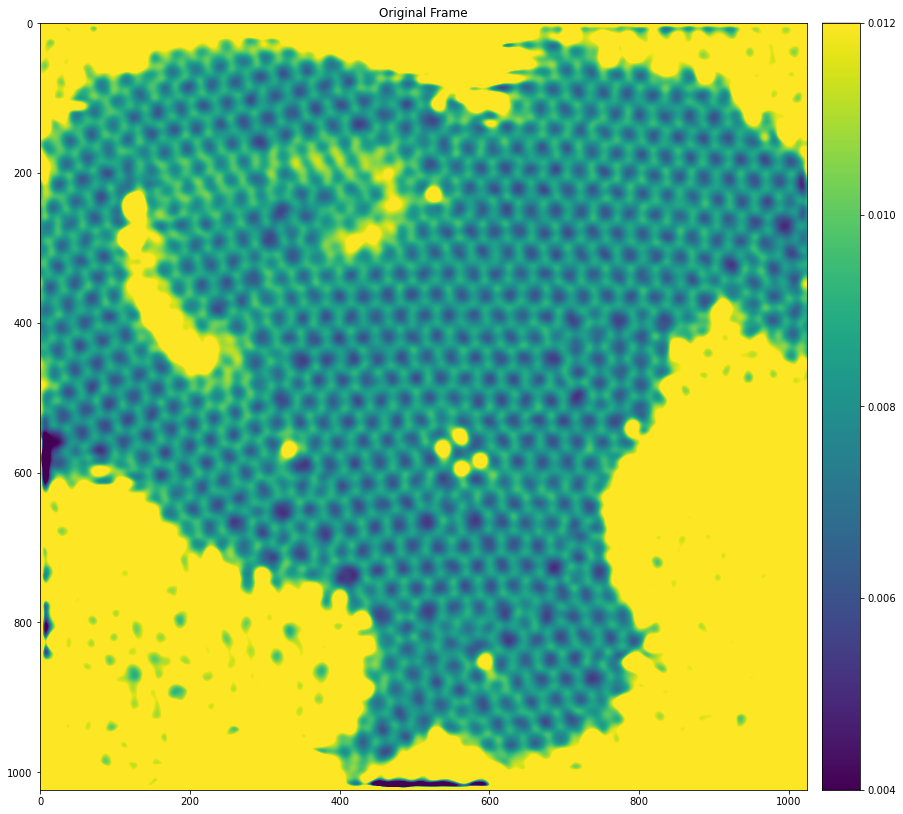

In [98]:
fig =plt.figure(1, figsize=(50, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(EMImage, cmap=plt.cm.viridis,vmax = 0.012, vmin = 0.004)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Original Frame")

In [99]:
border  = 40
min_threshold = 0.004
max_threshold = 0.011
for iring in range(ring_pos.shape[0]):
    x_pos= int(ring_pos[iring, 1])
    y_pos= int(ring_pos[iring, 0])
    x_start = x_pos - border
    y_start = y_pos - border
    x_end = x_pos + border
    y_end = y_pos + border
    if x_start<0:
        x_start = 0
    if y_start<0:
        y_start = 0
    if y_end>EMImage.shape[0]:
        y_end = EMImage.shape[0]
    if x_end>EMImage.shape[1]:
        x_end = EMImage.shape[1]
    sub= EMImage[y_start:y_end,x_start:x_end].copy()
    sub[np.where(sub>max_threshold)] = max_threshold
    sub[np.where(sub<min_threshold)] = min_threshold
    pts_idx=np.where((carbon_pos[:,0]>y_start)&(carbon_pos[:,0]<y_end)&(carbon_pos[:,1]>x_start)&(carbon_pos[:,1]<x_end))
    points = carbon_pos[pts_idx].copy()
    points[:,0] -= y_start
    points[:,1] -= x_start
    np.save('D:/GMM300/region'+str(iring)+'.npy', np.float32(sub))
    np.save('D:/GMM300/carbon_pos'+str(iring)+'.npy', np.float32(points))

In [100]:
def BondAngleLen(points, centerx, centery):
    points = np.concatenate((points, [[centery, centerx],]), axis = 0)
    vor = Voronoi(points)
    bond_angle = []
    bond_len = []
    ring_atoms = np.zeros((0, 2), points.dtype)
    for p1, region in enumerate(vor.point_region):
        # select the finite region
        if region<0:
            continue
        xpos = points[p1,0]
        ypos = points[p1,1]
        if np.abs(ypos-centery)>0.1:
            continue
        if np.abs(xpos-centerx)>0.1:
            continue
        #acquire the nearby three regions to compute bond length and bond angle.
        regions = []
        ridge_idx = []
        for iridge in range(vor.ridge_points.shape[0]):
            if vor.ridge_points[iridge, 0]==p1:
                regions.append(vor.ridge_points[iridge, 1])
                ridge_idx.append(iridge)
            if vor.ridge_points[iridge, 1]==p1:
                regions.append(vor.ridge_points[iridge, 0])
                ridge_idx.append(iridge)
        atoms = vor.points[regions]
        ring_atoms = np.concatenate((ring_atoms, atoms), axis = 0)
        verti_relation = np.asarray(vor.ridge_vertices)[ridge_idx]
        for iatom in range(len(regions)):
            shared_verti = verti_relation[iatom]
            #find the nearby two atoms for one atom.
            nearby_idx = []
            for iver in range(len(regions)):
                if iver == iatom:
                    continue
                if ((verti_relation[iver, 0] == shared_verti[0])|(verti_relation[iver, 1] == shared_verti[0])):
                    nearby_idx.append(iver)
                if ((verti_relation[iver, 0] == shared_verti[1])|(verti_relation[iver, 1] == shared_verti[1])):
                    nearby_idx.append(iver)
            #compute angle.
            len1 = np.sum((atoms[iatom] - atoms[nearby_idx[0]])*(atoms[iatom] - atoms[nearby_idx[0]]))
            len2 = np.sum((atoms[iatom] - atoms[nearby_idx[1]])*(atoms[iatom] - atoms[nearby_idx[1]]))
            len3 = np.sum((atoms[iatom] - atoms[nearby_idx[0]])*(atoms[iatom] - atoms[nearby_idx[1]]))
            bond_angle.append(np.arccos(len3/np.sqrt(len1*len2)))
            bond_len.append(np.sqrt(len1))
            bond_len.append(np.sqrt(len2))
    bond_angle = np.asarray(bond_angle)
    bond_len = np.unique(np.asarray(bond_len))
    return bond_angle, bond_len, ring_atoms

In [102]:
min_thresh = 12
ring_type = []
bond_angles = np.zeros((0,), np.float32)
bond_lens = np.zeros((0,), np.float32)
ring_carbon = np.zeros((0,2), carbon_pos.dtype)
for iring in range(ring_pos.shape[0]):
    x_pos= int(ring_pos[iring, 1])
    y_pos= int(ring_pos[iring, 0])
    x_start = x_pos - border
    y_start = y_pos - border
    x_end = x_pos + border
    y_end = y_pos + border
    if x_start<0:
        x_start = 0
    if y_start<0:
        y_start = 0
    if y_end>EMImage.shape[0]:
        y_end = EMImage.shape[0]
    if x_end>EMImage.shape[1]:
        x_end = EMImage.shape[1]
    pts_idx=np.where((carbon_pos[:,0]>y_start)&(carbon_pos[:,0]<y_end)&(carbon_pos[:,1]>x_start)&(carbon_pos[:,1]<x_end))
    if(pts_idx[0].shape[0]<1):
        continue
    points=np.load('D:/GMM300/carbon_det'+str(iring)+'.npy')
    points = points[0]
    #mesh the points
    bond_angle, bond_len, ring_atoms = BondAngleLen(points, x_pos - x_start, y_pos - y_start)
    ring_atoms[:, 0]+= x_start
    ring_atoms[:, 1]+= y_start
    if ring_atoms.shape[0]>4:
        ring_type.append(ring_atoms.shape[0])
    bond_lens = np.concatenate((bond_lens, bond_len))
    bond_angles = np.concatenate((bond_angles, bond_angle))
    #add the atoms around carbon ring.
    if(ring_carbon.shape[0] == 0):
        ring_carbon = np.concatenate((ring_carbon, ring_atoms), axis= 0)
        continue
    dist_mat = distance_matrix(ring_carbon, ring_atoms)
    min_dist= np.min(dist_mat, axis=0)
    far_idx = np.where(min_dist>=min_thresh)
    ring_atoms = ring_atoms[far_idx]
    ring_carbon = np.concatenate((ring_carbon, ring_atoms), axis= 0)
ring_carbon = np.roll(ring_carbon, 1, axis= 1)
ring_type = np.asarray(ring_type)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


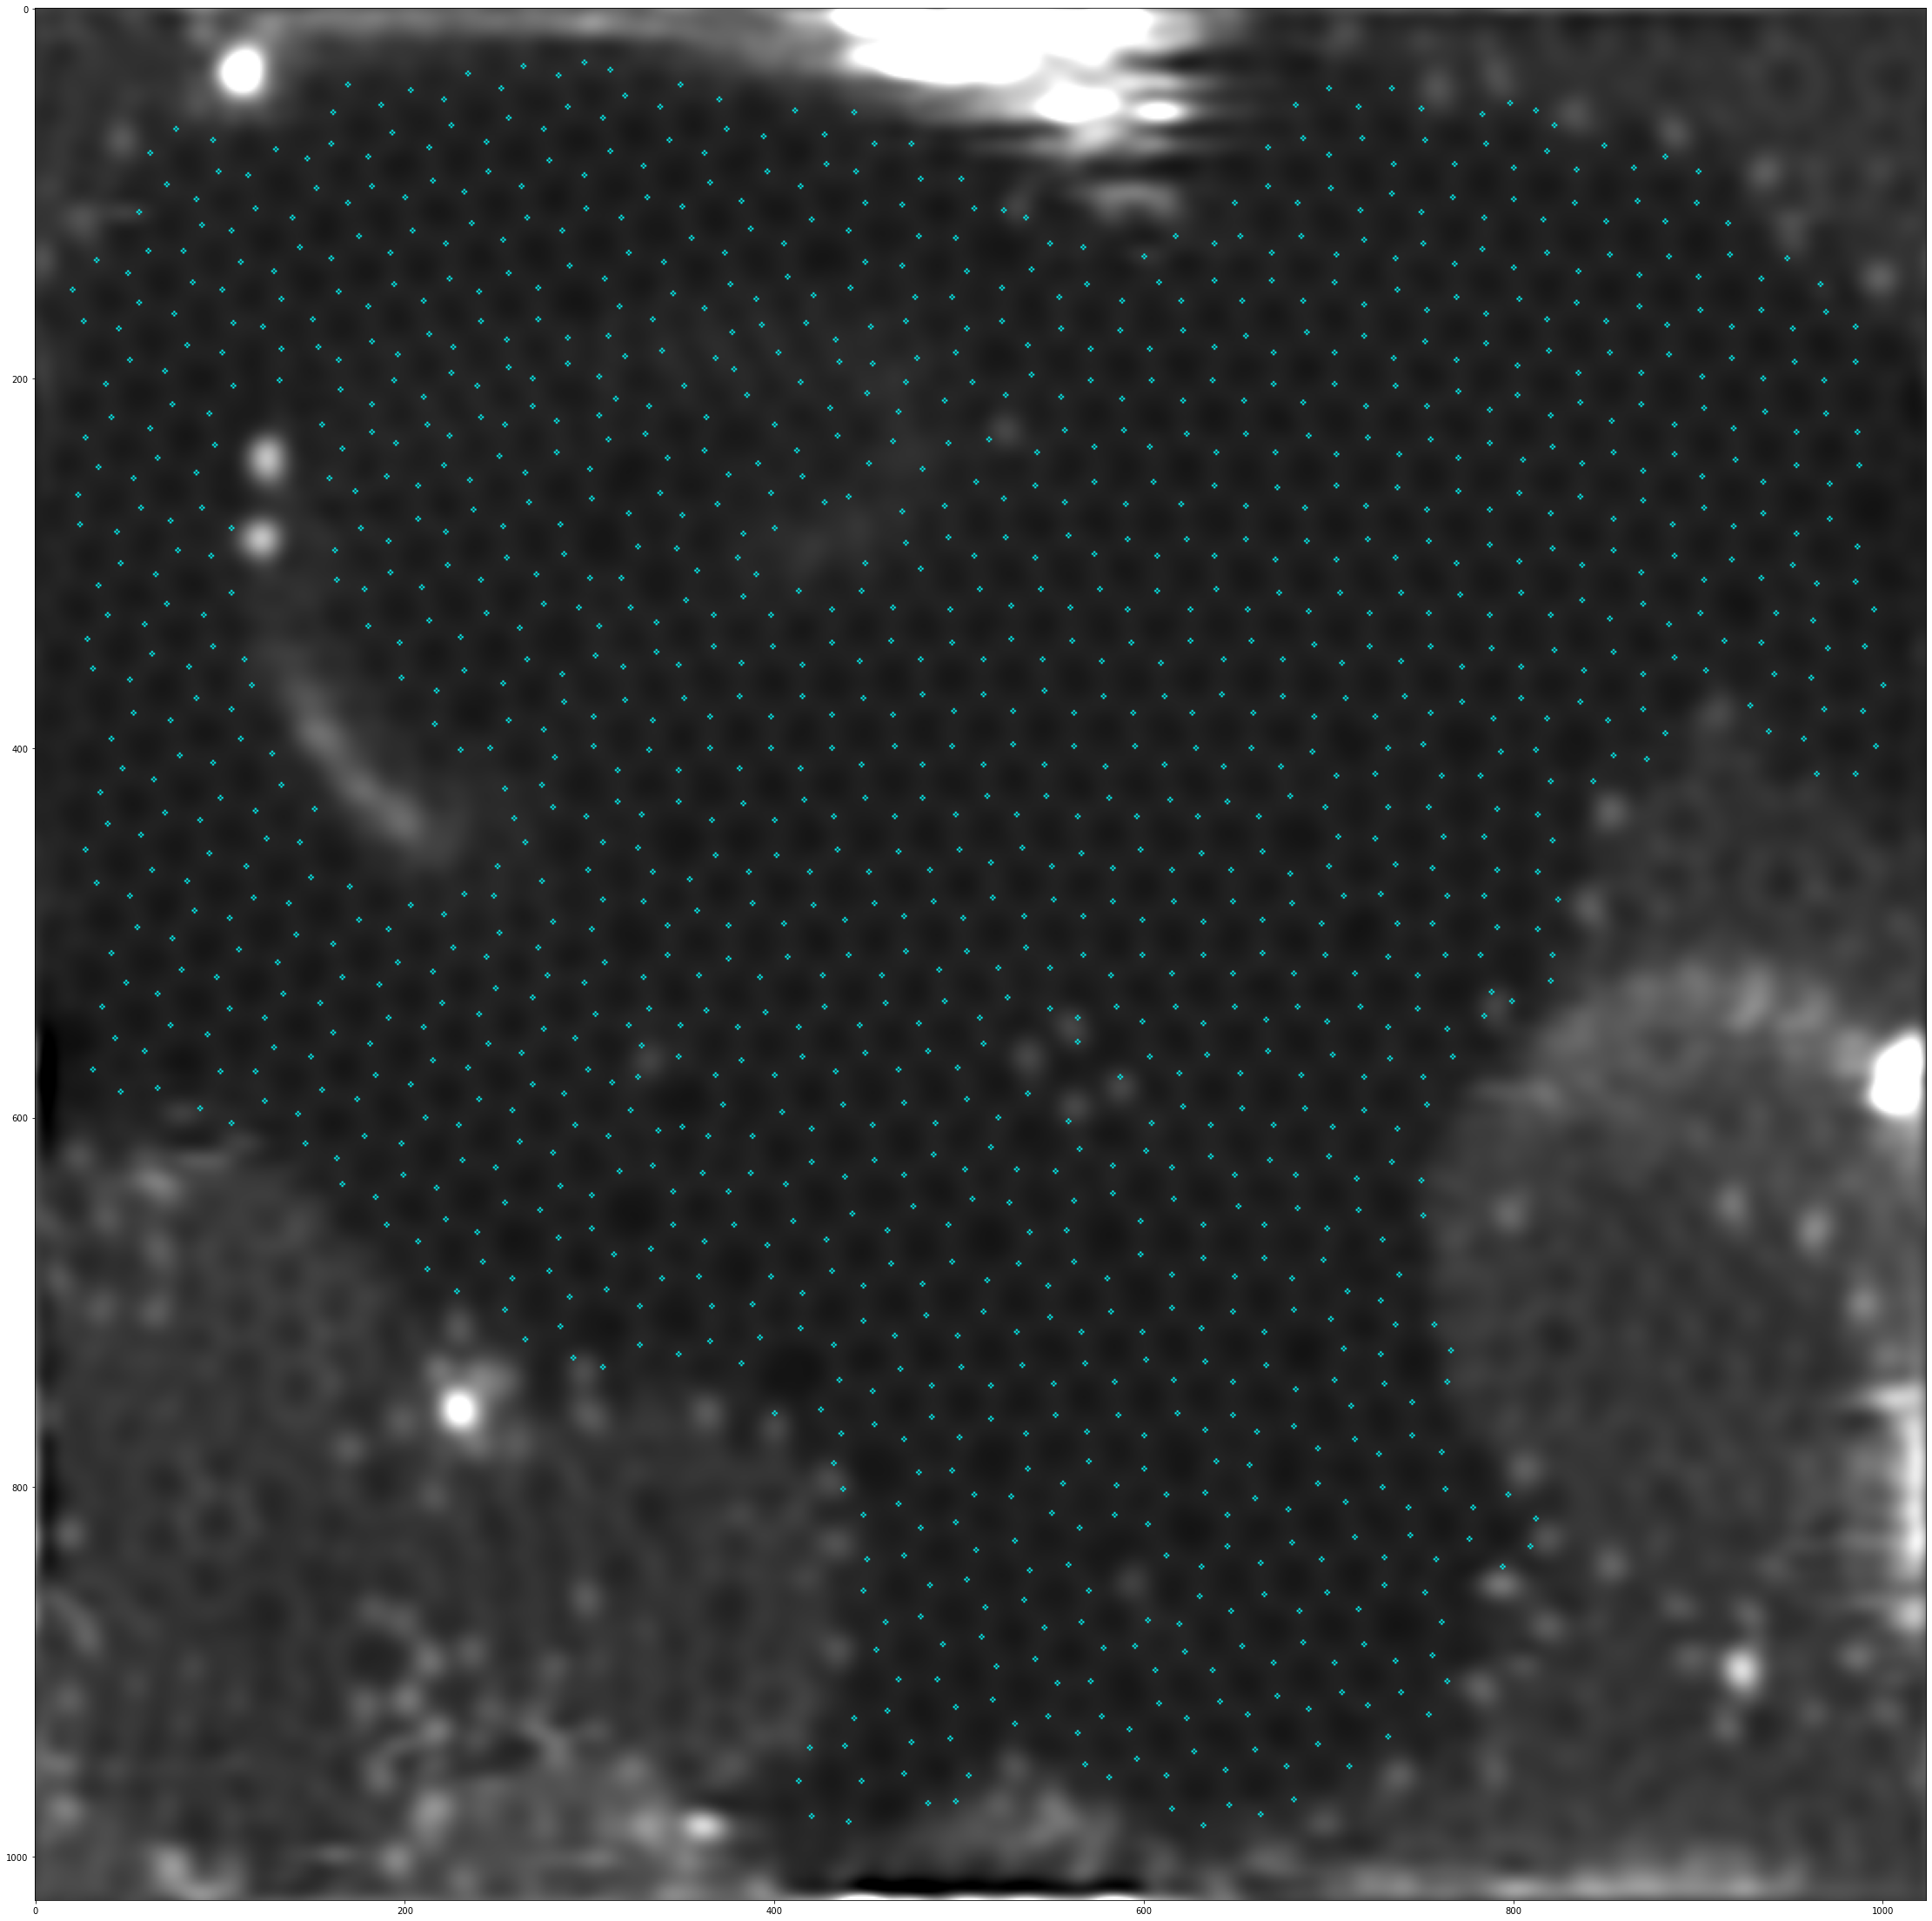

In [103]:
#show the points
rgb_frame=cv2.cvtColor(3.0*np.float32(EMImage)/np.float32(np.max(EMImage)), cv2.COLOR_GRAY2BGR)
for i in range(ring_carbon.shape[0]):
    cv2.circle(rgb_frame,(int(ring_carbon[i,1]),int(ring_carbon[i,0])),1,(0,255,255))
plt.figure(figsize=(40,40))
plt.imshow(rgb_frame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


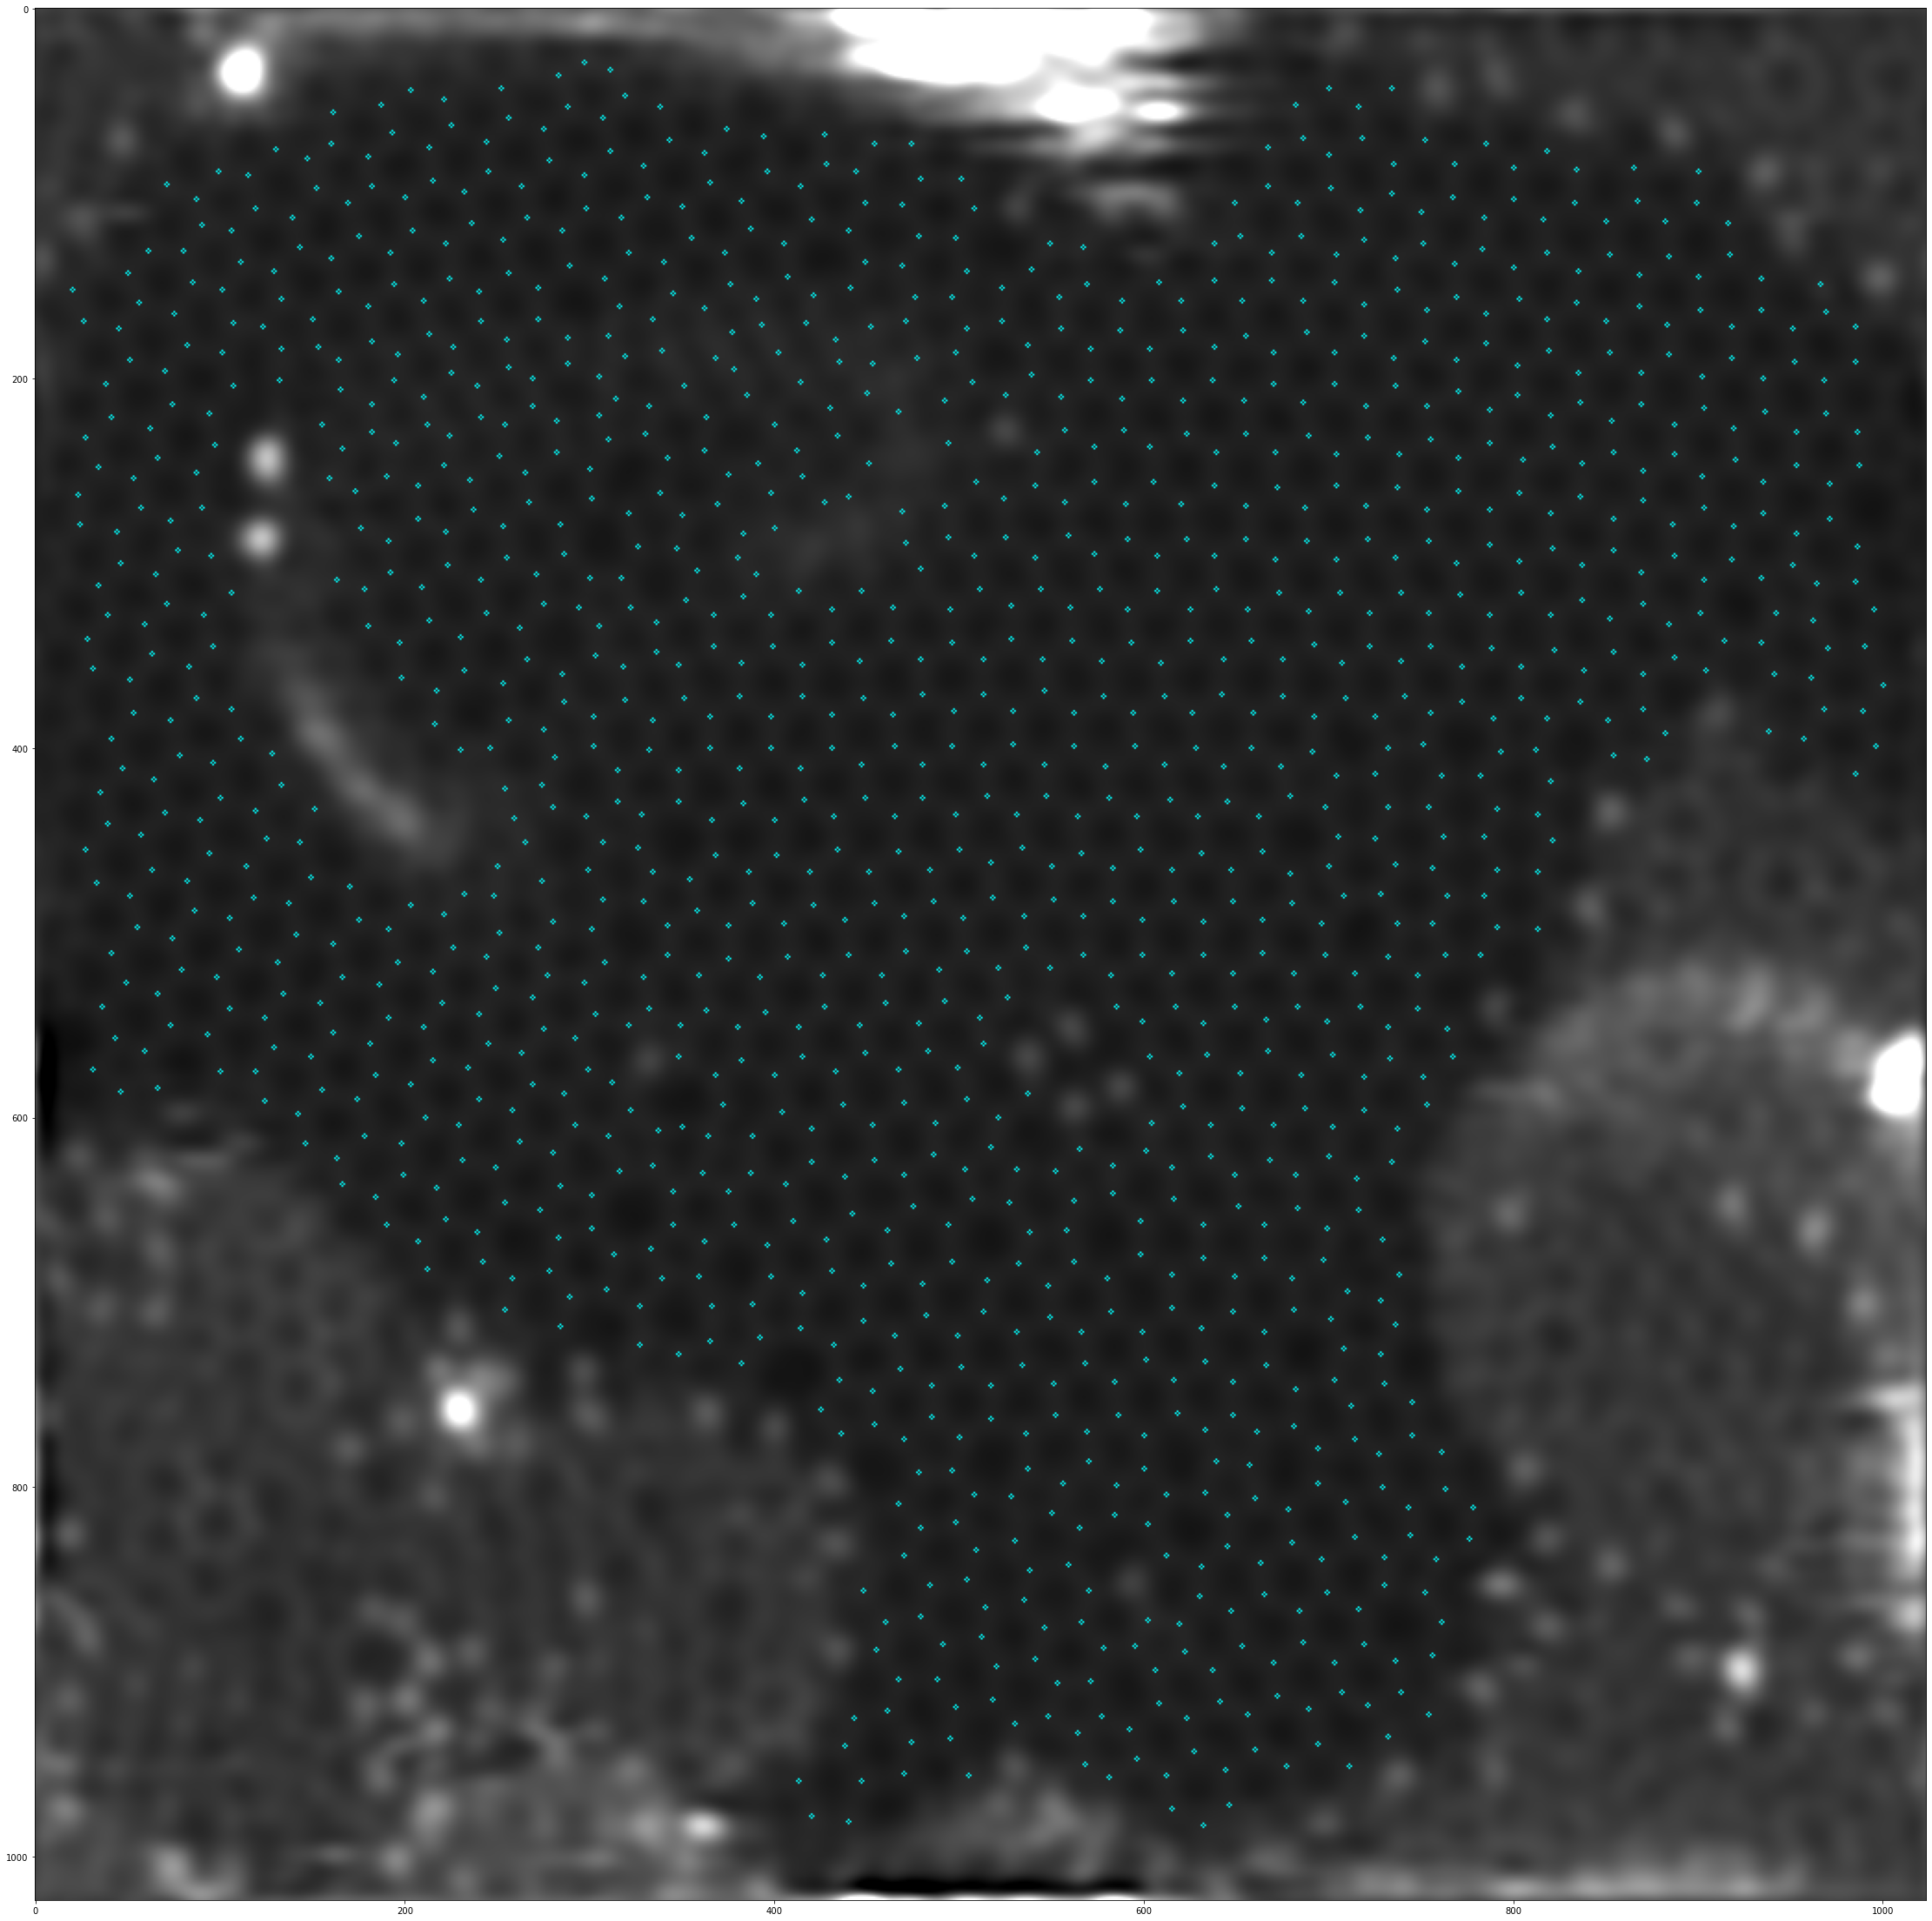

In [104]:
#simple remove 
box = 6
bound = 20
fcarbon_pos= []
max_threshold = 0.012
min_threshold = 0.004
for icarbon in range(ring_carbon.shape[0]):
    x_pos = int(ring_carbon[icarbon, 1])
    y_pos = int(ring_carbon[icarbon, 0])
    if x_pos < bound: 
        continue
    if y_pos < bound: 
        continue
    if x_pos > EMImage.shape[1]-bound: 
        continue
    if y_pos > EMImage.shape[0]-bound: 
        continue
    sub_image = EMImage[y_pos-box:y_pos+box,x_pos-box:x_pos+box]
    if (np.max(sub_image)<max_threshold) & (np.min(sub_image)>min_threshold):
        fcarbon_pos.append(ring_carbon[icarbon])
ring_carbon = np.asarray(fcarbon_pos)
rgb_frame=cv2.cvtColor(3.0*np.float32(EMImage)/np.float32(np.max(EMImage)), cv2.COLOR_GRAY2BGR)
for i in range(ring_carbon.shape[0]):
    cv2.circle(rgb_frame,(int(ring_carbon[i,1]),int(ring_carbon[i,0])),1,(0,255,255))
plt.figure(figsize=(40,40))
plt.imshow(rgb_frame)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


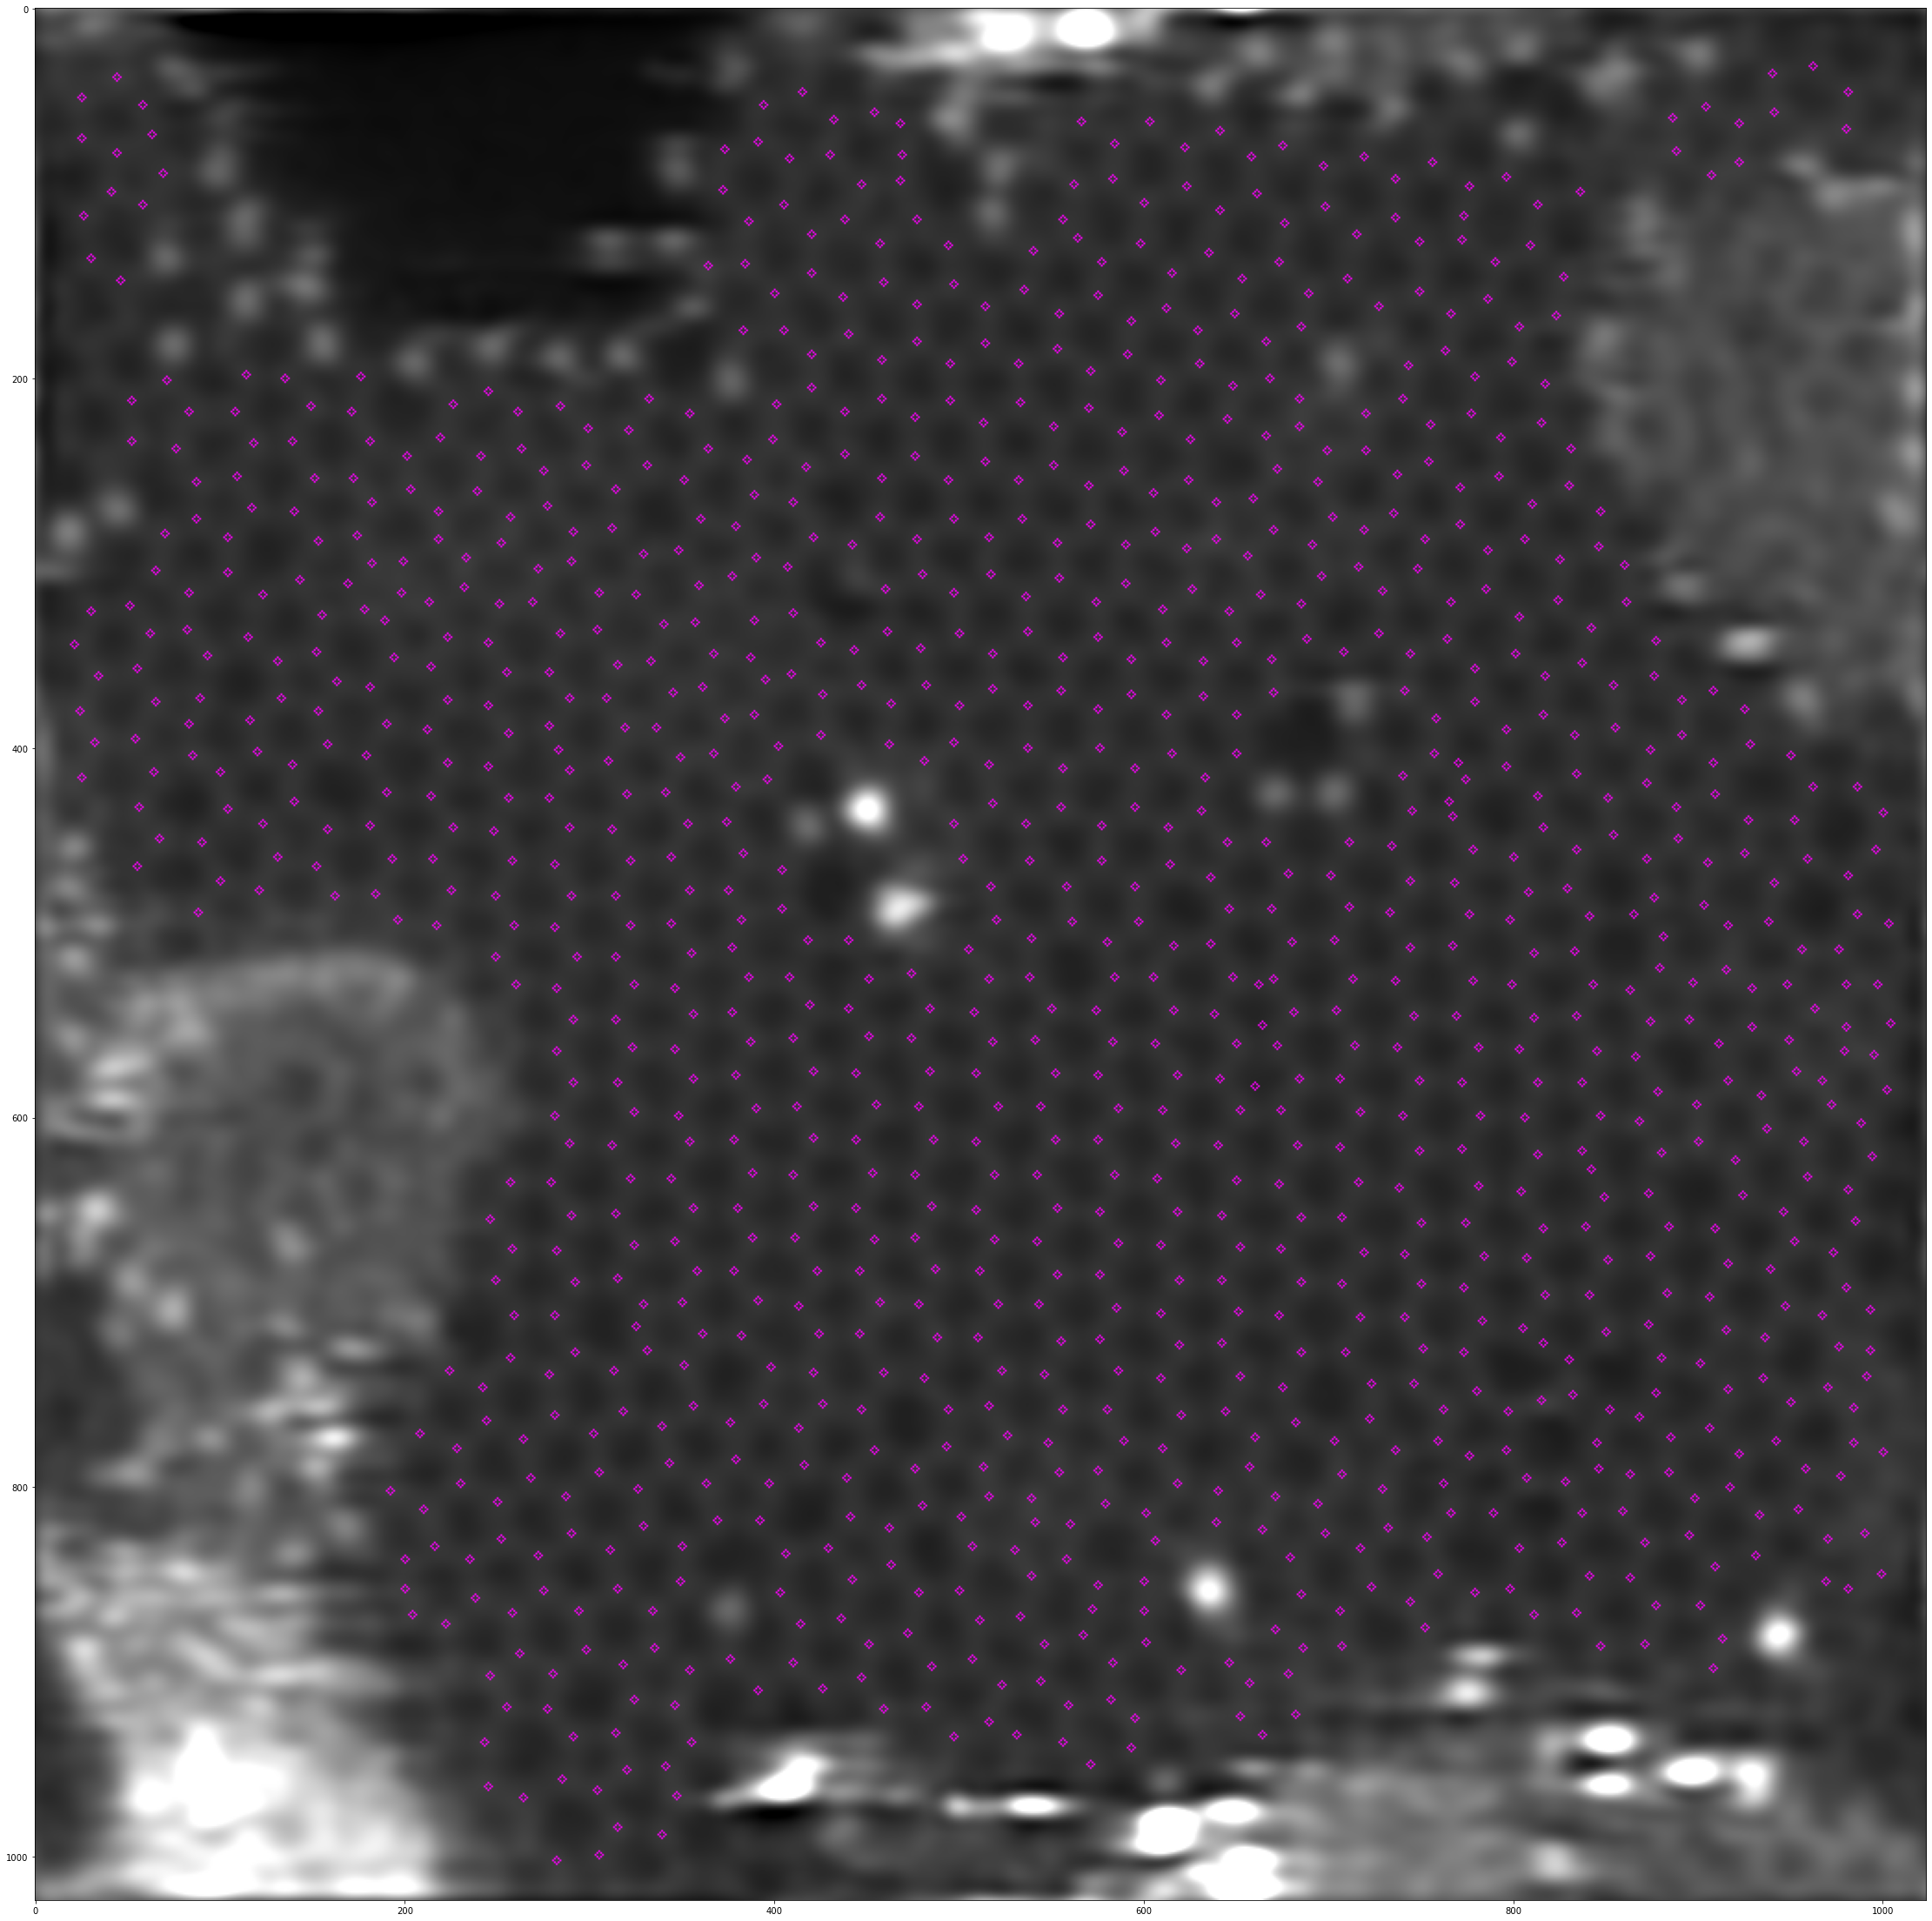

In [63]:
#manual remove(y= 402, x = 330)
point = np.array([[-10, -10],])
dist_array = distance_matrix(ring_carbon, point)[:,0]
matched_idx = np.where(dist_array<=3.0)[0]
fring_carbon = np.delete(ring_carbon, matched_idx, 0)
#manual add point
nring_carbon = np.concatenate((fring_carbon, np.array([[528, 662],[550, 664],[583, 660],[408, 770],[429, 765],])))
rgb_frame=cv2.cvtColor(3.0*np.float32(EMImage)/np.float32(np.max(EMImage)), cv2.COLOR_GRAY2BGR)
for i in range(nring_carbon.shape[0]):
    cv2.circle(rgb_frame,(int(nring_carbon[i,1]),int(nring_carbon[i,0])),2,(255,0,255))
plt.figure(figsize=(40,40))
plt.imshow(rgb_frame)

In [105]:
np.save("bond length.npy", bond_lens)
np.save("bond angle.npy", bond_angles)
np.save("carbon_pos.npy", ring_carbon)
np.save("ring type.npy", ring_type)